In [1]:
### this notebook is about RNN on predicting daily S&P500 VIX using non-overlapping X-training, eposchs = 30
import pandas as pd ### this automatically will call up 'from pandas import read_csv' when pd.read.csv... is used
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
### imports apps (specialized functions)

In [2]:
Vx = pd.read_csv("VIX.csv")  
print(Vx)

            Date       Open       High        Low      Close  Adj Close  \
0       2/1/1990  17.240000  17.240000  17.240000  17.240000  17.240000   
1       3/1/1990  18.190001  18.190001  18.190001  18.190001  18.190001   
2       4/1/1990  19.219999  19.219999  19.219999  19.219999  19.219999   
3       5/1/1990  20.110001  20.110001  20.110001  20.110001  20.110001   
4       8/1/1990  20.260000  20.260000  20.260000  20.260000  20.260000   
...          ...        ...        ...        ...        ...        ...   
8265  20/10/2022  31.299999  31.320000  29.760000  29.980000  29.980000   
8266  21/10/2022  30.209999  30.440001  29.240000  29.690001  29.690001   
8267  24/10/2022  30.650000  30.950001  29.780001  29.850000  29.850000   
8268  25/10/2022  29.799999  30.000000  28.219999  28.459999  28.459999   
8269  26/10/2022  28.440001  28.520000  27.270000  27.280001  27.280001   

      Volume  
0          0  
1          0  
2          0  
3          0  
4          0  
...      

In [3]:
VIX=Vx["Adj Close"] 
### if we use VIX=Vx.iloc[:, 5:6].values -- then we get VIX as a numpy array and we need to convert back to pandas before
### we can use some pandas print and plot functions
print(VIX)

0       17.240000
1       18.190001
2       19.219999
3       20.110001
4       20.260000
          ...    
8265    29.980000
8266    29.690001
8267    29.850000
8268    28.459999
8269    27.280001
Name: Adj Close, Length: 8270, dtype: float64


Text(0.5, 1.0, 'Historical Daily VIX Measures 2 Jan 1990 to 26 Oct 2022')

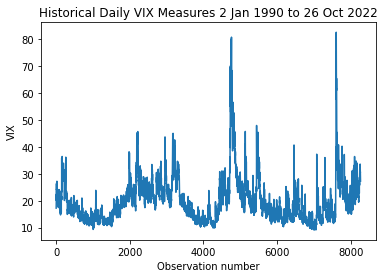

In [4]:
### view time series graph of data -- is it stationary?
VIX.plot()
plt.xlabel('Observation number')
plt.ylabel('VIX')
plt.title('Historical Daily VIX Measures 2 Jan 1990 to 26 Oct 2022')

In [5]:
### we cannot use 'train_data = VIX.sample(frac=0.8, random_state=1); test_data = VIX.drop(train_data.index)'
### as this is time series data that is sequenced and cannot be randomly chopped up
split_percent=0.8    
n = len(VIX) ### len() is a numpy array function
split = int(n*split_percent) ### point for splitting data into train and test
train_data = VIX[range(split)]
test_data = VIX[split:]

In [6]:
train_data.shape, test_data.shape  ### 0.8 x 8270 = 6616

((6616,), (1654,))

In [7]:
type(train_data), type(test_data)

(pandas.core.series.Series, pandas.core.series.Series)

In [8]:
train_data.values.reshape(-1, 1)

array([[17.24    ],
       [18.190001],
       [19.219999],
       ...,
       [13.95    ],
       [13.1     ],
       [14.12    ]])

In [9]:
#Performing Feature Scaling
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))  ### putting all positive is suitable as vola are all pos nos.
train_data = scaler.fit_transform(train_data.values.reshape(-1, 1)) ### (-1,1) reshapes it to a 2D array; 
### without .values - it may not work; .values .values convert to np array, the axes labels will be removed.
test_data = scaler.fit_transform(test_data.values.reshape(-1, 1)) ### (-1,1) reshapes it to a 2D array

In [10]:
type(train_data), type(test_data)

(numpy.ndarray, numpy.ndarray)

In [11]:
train_data.shape, test_data.shape

((6616, 1), (1654, 1))

Text(0.5, 1.0, 'Historical Daily Scaled VIX Measures 2 Jan 1990 to 4 Apr 2016')

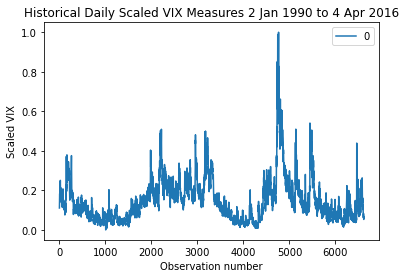

In [12]:
### view scaled time series graph of data -- need to convert np array back to pandas df to use plot feature
trdata=pd.DataFrame(train_data)
trdata.plot()
plt.xlabel('Observation number')
plt.ylabel('Scaled VIX')
plt.title('Historical Daily Scaled VIX Measures 2 Jan 1990 to 4 Apr 2016')

In [13]:
### Preparing the input X and target Y
def get_XY(dat, time_steps):
    ### Indices of target array
    C_ind = np.arange(time_steps, len(dat), time_steps) 
        ### example np.arange(start=1, stop=10, step=3) gives array([1, 4, 7]), ends up to/before stop
    C = dat[C_ind]
        ### example: ray=np.arange(2, stop=10, step=3); print(ray) --- gives [2 5 8]
        ### c=np.array([1,3,6,8,9,10,12,15,18,20]); c[ray] --- gives array([ 6, 10, 18]) 
        ### with elements from the 2nd, 5th, 8th positions of c. c's 1st position starts at '0'

    ### Prepare X
    rows_x = len(C)                              ### here len(C) is 661 
    X = dat[range(time_steps*rows_x)]            ### range(L) is 0,1,2,..., L-1. L is 10 x 661 = 6610. X is array 1,2,...,6610
    X = np.reshape(X, (rows_x, time_steps, 1))   ### X rshaped as (661,10,1) 
    return X, C
 
time_steps = 10  ### hence C_ind = array ([10, 20, 30, 40, ....,661]), 661 number of 10 steps
                 ### C = array(10th position, 20th position of dat, etc.) 
                 ### -- approx two weeks (10 trading days) interval for one prediction point of VIX
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [14]:
len(train_data), type(train_data)

(6616, numpy.ndarray)

In [15]:
trainX.shape, trainY.shape 
### trainX has 661 elements in dimension 1, each with 10 elements in dimension 2; 1st element in dim 1 has first 10 data points, 
### 2nd element in dim 1 has next 10 data points, etc.
### train Y has 661 elements in dimension 1 and trivial dimension 2 -- essentially one column

((661, 10, 1), (661, 1))

In [16]:
testX.shape, testY.shape 
### testX has 165 elements in dimension 1, each with 10 elements in dimension 2; 1st element in dim 1 has first 10 data points, 
### 2nd element in dim 1 has next 10 data points, etc.
### testY has 165 elements in dimension 1 and trivial dimension 2 -- essentially one column

((165, 10, 1), (165, 1))

In [17]:
print(trainX[0,0:10,:],trainY[1,:])
print(trainX[1,0:10,:],trainY[2,:])
print(trainX[2,0:10,:],trainY[3,:])
print(trainX[660,0:10,:],trainY[660,:])
### the printed shows first ten elements/inputs in trainX matched against the 11th element (1st element of trainY)
### then shows the last (661) ten elements in trainX against the 661th element in trainY

[[0.11083158]
 [0.12410903]
 [0.13850453]
 [0.15094341]
 [0.15303983]
 [0.18015375]
 [0.18350805]
 [0.15010481]
 [0.21425575]
 [0.23801537]] [0.25073375]
[[0.20782669]
 [0.20754717]
 [0.21006289]
 [0.18434661]
 [0.24304683]
 [0.21537385]
 [0.22473793]
 [0.22809223]
 [0.23717681]
 [0.23941301]] [0.20195667]
[[0.25073375]
 [0.22431867]
 [0.21747031]
 [0.20978337]
 [0.21285815]
 [0.21495459]
 [0.20936409]
 [0.20209643]
 [0.20097835]
 [0.21062193]] [0.17721873]
[[0.10048917]
 [0.10635919]
 [0.10524109]
 [0.07938504]
 [0.07169811]
 [0.06582809]
 [0.06261356]
 [0.06792453]
 [0.07868623]
 [0.07589098]] [0.0828791]


In [18]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
       ### See SimpleRNN apps in https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN 
    model.add(Dense(units=dense_units, activation=activation[1]))
       ### Using model = Sequential() allows defining -- no. of inputs,#neurons in hidden,#neurons in output layer 
    model.compile(loss='mean_squared_error', optimizer='adam')   
       ### .compile in Sequential carries loss and optimizer options 
    return model

In [19]:
# Create model and train
model1 = create_RNN(hidden_units=8, dense_units=1, input_shape=(time_steps,1), activation=['tanh', 'tanh'])
   ### calls function create_RNN, fills in the arguments that were sub-defined in last codeline via .add that defines operations
   ###   at the input layer and at the hidden layer and at dense/output layer
### hidden_units = 8 means that there are 8 neurons in each hidden layer
### input_shapes = (time-steps,1) with time_steps=10 means that each time-step in a pack of 10 is an input 
###   (the output for that time-step is ignored) -- only the end of pack time variable is used in trainY

model1.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2)
   ### time series of trainX is reshaped as (661,10,1), trainY is (661,)
   ### time series of testX is (165, 10, 1)), testY is (165,)
   ### The 6616 sequence points in trainX are separated into 661 "separate" non-overlapping packs of 10 sequential points each.
   ###  In the training, trainY is matched against predicted using trainX of each of the 661 "separate" packs

   ###  As in MLP or ANN, the parameter update (parameter same for each of the 661 packs or through the entire time series)
   ###    can occur at each pack, i.e. batch_size=1, or can occur for any batch_size or packs up to 661.
      ###  if we use batch_size=1, then each epoch has 661 batches -- 661 x 1 = 661 
      ###  if we use batch_size=2, then each epoch has 331 batches -- 331 + 330 = 661
      ###  if we use batch_size=3, then each epoch has 221 batches -- 221 x 2 + 219 = 661 and so on

   ### IMPORTANT to note when all batches are run -- one epoch is completed. More epochs means updating by running across
   ###  the entire time series one more time etc.

### make predictions
train_predict = model1.predict(trainX) ### Using the fitted model with trainX, trainY
test_predict = model1.predict(testX)   ### Using the same fitted model with trainX, trainY
 
### above, more appropriately test_predict is run after train_predict error is minimized or loss is minimized after the
### training set trainX, trainY are used in .fit -- and then the hyperparameters are tuned, before applying in a separate 
### model1.fit to the testX, testY data. Above assumes the model1.fit on trainX, trainY is already the optimal one

### what is dense unit above: Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation 
### is the element-wise activation function passed as the activation -- Dense occurs at hidden and output layers
### By setting verbose 0, 1 or 2 you just say how do you want to 'see' the training progress for each epoch.
###    verbose=0 will show you nothing (silent)/ verbose=1 will show you an animated progress bar like this: progress_bar
###    verbose=2 will just mention the number of epoch like this, most detailed: 
###         Epoch 30/30
###         661/661 - 1s - loss: 5.5611e-04 - 540ms/epoch - 817us/step

Epoch 1/30
661/661 - 1s - loss: 0.0131 - 885ms/epoch - 1ms/step
Epoch 2/30
661/661 - 1s - loss: 0.0018 - 510ms/epoch - 772us/step
Epoch 3/30
661/661 - 1s - loss: 0.0013 - 519ms/epoch - 785us/step
Epoch 4/30
661/661 - 1s - loss: 0.0011 - 525ms/epoch - 794us/step
Epoch 5/30
661/661 - 1s - loss: 9.2497e-04 - 508ms/epoch - 769us/step
Epoch 6/30
661/661 - 1s - loss: 8.8433e-04 - 515ms/epoch - 779us/step
Epoch 7/30
661/661 - 1s - loss: 7.7958e-04 - 523ms/epoch - 791us/step
Epoch 8/30
661/661 - 1s - loss: 7.6770e-04 - 525ms/epoch - 794us/step
Epoch 9/30
661/661 - 1s - loss: 7.7132e-04 - 526ms/epoch - 795us/step
Epoch 10/30
661/661 - 1s - loss: 7.2427e-04 - 520ms/epoch - 787us/step
Epoch 11/30
661/661 - 1s - loss: 6.5498e-04 - 542ms/epoch - 820us/step
Epoch 12/30
661/661 - 1s - loss: 6.5590e-04 - 553ms/epoch - 837us/step
Epoch 13/30
661/661 - 1s - loss: 6.3335e-04 - 536ms/epoch - 811us/step
Epoch 14/30
661/661 - 1s - loss: 6.1072e-04 - 532ms/epoch - 805us/step
Epoch 15/30
661/661 - 1s - loss: 

In [20]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [21]:
def print_error(trainY, testY, train_predict, test_predict):    
    ### Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    ### Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))
    
print_error(trainY, testY, train_predict, test_predict)

Train RMSE: 0.023 RMSE
Test RMSE: 0.024 RMSE


In [22]:
### See also https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvline.html
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='b', linestyle='--')  ### note the vertical red line is drawn to separate the training part from test part
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('VIX Measures scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

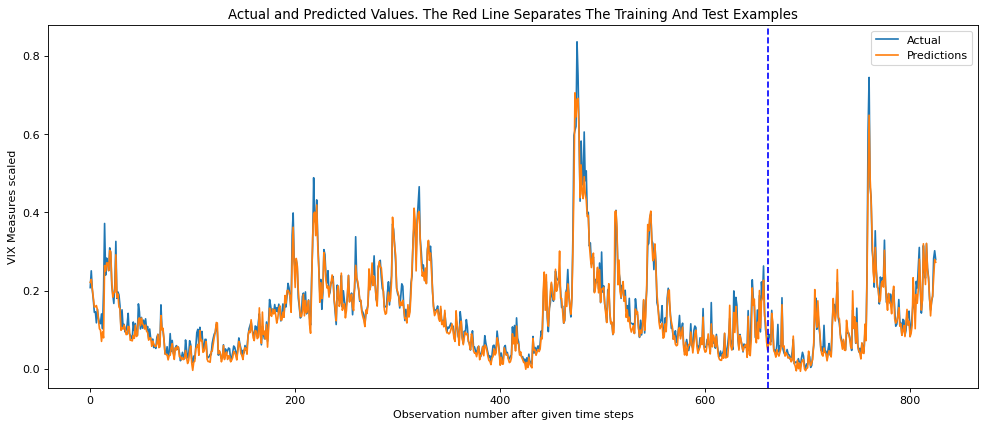

In [23]:
### Plot result -- this puts together Actual = (trainY,testY) or 187+46 points, and Predicted = (train_predict, test_predict)
plot_result(trainY, testY, train_predict, test_predict)

In [24]:
trainY1 = scaler.inverse_transform(trainY)
testY1 = scaler.inverse_transform(testY)
train_predict1 = scaler.inverse_transform(train_predict)
test_predict1 = scaler.inverse_transform(test_predict)

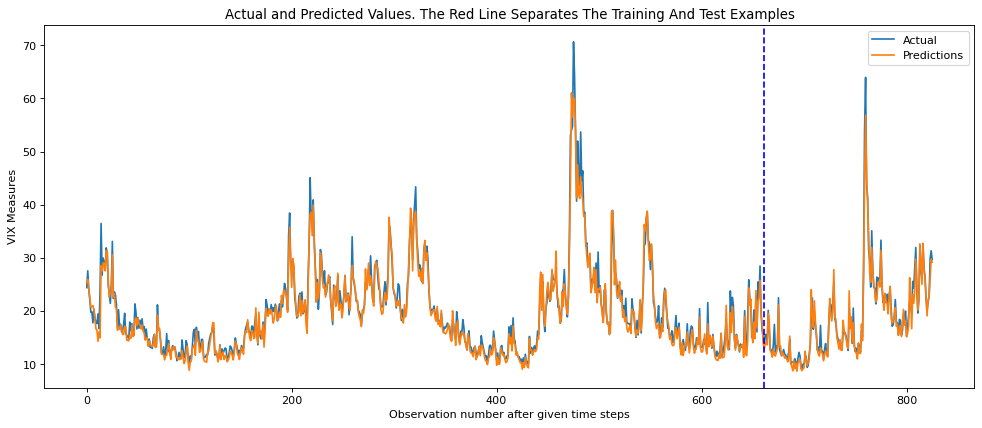

In [25]:
### See also https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvline.html
def plot_result(trainY1, testY1, train_predict1, test_predict1):
    actual = np.append(trainY1, testY1)
    predictions = np.append(train_predict1, test_predict1)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY1), color='b', linestyle='--') ### note: vertical red line separates training part from test part
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('VIX Measures')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
    ### Plot result -- this puts together Actual = (trainY,testY) or 187+46 points, 
    ### and Predicted = (train_predict, test_predict)
plot_result(trainY1, testY1, train_predict1, test_predict1)

In [26]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA

In [27]:
mod = sm.tsa.arima.ARIMA(train_data,order=(1, 0, 1))
>>> model_fit = mod.fit()
>>> print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6616
Model:                 ARIMA(1, 0, 1)   Log Likelihood               16090.561
Date:                Mon, 31 Oct 2022   AIC                         -32173.123
Time:                        22:18:23   BIC                         -32145.934
Sample:                             0   HQIC                        -32163.727
                               - 6616                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1470      0.020      7.217      0.000       0.107       0.187
ar.L1          0.9847      0.001    900.988      0.000       0.983       0.987
ma.L1         -0.0948      0.006    -16.553      0.0

In [28]:
forecast_test=model_fit.forecast(len(test_data))
rmse = mean_squared_error(forecast_test, test_data)
rmse

0.012958748767040994